# 1. Define binning and model

In [1]:
import glob
import numpy as np
import pandas
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.cm as cm
from tqdm import tqdm
import pyhf
import cabinetry
cabinetry.set_logging()
import json
import yaml
plt.rcParams["axes.prop_cycle"] = plt.cycler("color", plt.cm.tab20.colors)
#pyhf.set_backend('numpy','minuit')

In [2]:
# Define the range and number of bins
start = -0.4
end = 0.4
num_bins = 20

# Create the bin edges
bins = np.linspace(start, end, num_bins + 1)

# Check for empty bins
# empty_bins = [41, 42, 43, 44, 46, 47, 48, 49]

# Merge adjacent empty bins
# merged_bins = np.delete(bins, empty_bins)

In [3]:
# define cabinetry configuration
config = {
   "General":{
      "Measurement": "B2Kpi0",
      "POI": "signal_norm",              # parameter of interest, which we want to measure 
      "InputPath": "Ntuples/{SamplePath}",       # where to find input data
      "HistogramFolder": "histograms/"

   }
}

config.update({
   "Regions":[
      {
         "Name": "signal_region",
         "Filter": "(abs(B_deltaE)<0.4) & (B_R2<0.45) & (B_cosTBTO<0.8)",           # event selection 
         "Variable": "B_deltaE",             # which variable we bin histograms in
         "Binning": list(bins)
      }
   ]
})

config.update({
   "Samples":[
      {
         "Name": "Data",
         "Tree": "Bsig",
         "SamplePath": ['MC15ri_b_Kpi0_generic_200fb_8/charged.root',
                        'MC15ri_b_Kpi0_generic_200fb_8/mixed.root',
                        'MC15ri_b_Kpi0_generic_200fb_8/ssbar.root',
                        'MC15ri_b_Kpi0_generic_200fb_8/ccbar.root'],
         "Data": True                       # observed data is handled differently, need to distinguish
      },
      {
         "Name": "signal",
         "Tree": "Bsig",
         "SamplePath": ["MC15ri_b_Kpi0_signal_8/00.root"],
         "Weight": '0.015'                 # weights: Monte Carlo integration, simulation correction etc.
      },
      {
         "Name": "qqbar",
         "Tree": "Bsig",
         "SamplePath": ['MC15ri_b_Kpi0_generic_200fb_9/ssbar.root',
                        'MC15ri_b_Kpi0_generic_200fb_9/ccbar.root'],
         "Weight": "__weight__"
      },
       {
         "Name": "BBbar",
         "Tree": "Bsig",
         "Filter": "(B_mcErrors>0) & (B_mcErrors!=128) & (abs(B_deltaE)<0.4) & (B_R2<0.45) & (B_cosTBTO<0.8)",
         "SamplePath": ['MC15ri_b_Kpi0_generic_200fb_9/charged.root',
                        'MC15ri_b_Kpi0_generic_200fb_9/mixed.root'],
         "Weight": "__weight__"                 # weights: Monte Carlo integration, simulation correction etc.
      },
       {
         "Name": "misID",
         "Tree": "Bsig",
         "Filter": "(B_mcErrors==128) & (abs(B_deltaE)<0.4) & (B_R2<0.45) & (B_cosTBTO<0.8)",
         "SamplePath": ["MC15ri_b_Kpi0_misID/misID.root"],
         "Weight": '0.001'                 # weights: Monte Carlo integration, simulation correction etc.
      }
   ]
})

config.update({"Systematics": []})

config.update({
   "NormFactors":[
      {
         "Name": "signal_norm",
         "Samples": "signal",    # we want this parameter to scale the signal
         "Nominal": 1,
         "Bounds": [0, 5]
      },
        {
         "Name": "qqbar_norm",
         "Samples": "qqbar",
         "Nominal": 1,
         "Bounds": [0, 5]
      },
       {
         "Name": "BBbar_norm",
         "Samples": "BBbar",
         "Nominal": 1,
         "Bounds": [0, 5]
      },
        {
         "Name": "misID_norm",
         "Samples": "misID",
         "Nominal": 1,
         "Bounds": [0, 5]
      }
   ]
})


# config.update({
#    "Systematics":[
#       {
#          "Name": "Luminosity",
#          "Up": {"Normalization": 0.05},
#          "Down": {"Normalization": -0.05},
#          "Type": "Normalization"
#       },
#       {
#          "Name":"Modeling",
#          "Up": {"Tree": "B"},
#          "Down": {"Symmetrize": True},
#          "Samples": "signal",
#          "Type": "NormPlusShape"
#       },
#       {
#          "Name": "WeightBasedModeling",
#          "Up": {"Weight": "__weight__"},
#          "Down": {"Weight": "0.7*__weight__"},
#          "Samples": "qqbar",
#          "Type": "NormPlusShape"
#       }
#    ],
# })

In [4]:
cabinetry.configuration.validate(config)

True

In [5]:
cabinetry.configuration.print_overview(config)

INFO - cabinetry.configuration - the config contains:
INFO - cabinetry.configuration -   5 Sample(s)
INFO - cabinetry.configuration -   1 Regions(s)
INFO - cabinetry.configuration -   4 NormFactor(s)
INFO - cabinetry.configuration -   0 Systematic(s)


In [6]:
cabinetry.templates.build(config, method="uproot")

DEBUG - cabinetry.route -   in region signal_region
DEBUG - cabinetry.route -     reading sample Data
DEBUG - cabinetry.route -       variation Nominal
DEBUG - cabinetry.histo - saving histogram to histograms/signal_region_Data.npz
DEBUG - cabinetry.route -     reading sample signal
DEBUG - cabinetry.route -       variation Nominal
DEBUG - cabinetry.histo - saving histogram to histograms/signal_region_signal.npz
DEBUG - cabinetry.route -     reading sample qqbar
DEBUG - cabinetry.route -       variation Nominal
DEBUG - cabinetry.histo - saving histogram to histograms/signal_region_qqbar.npz
DEBUG - cabinetry.route -     reading sample BBbar
DEBUG - cabinetry.route -       variation Nominal
WARNING - cabinetry.histo - signal_region_BBbar has empty bins: [10 11 13 14 15 16 17 18 19]
DEBUG - cabinetry.histo - saving histogram to histograms/signal_region_BBbar.npz
DEBUG - cabinetry.route -     reading sample misID
DEBUG - cabinetry.route -       variation Nominal
DEBUG - cabinetry.histo - 

In [7]:
cabinetry.templates.postprocess(config)

DEBUG - cabinetry.route -   in region signal_region
DEBUG - cabinetry.route -     reading sample Data
DEBUG - cabinetry.route -       variation Nominal
DEBUG - cabinetry.histo - saving histogram to histograms/signal_region_Data_modified.npz
DEBUG - cabinetry.route -     reading sample signal
DEBUG - cabinetry.route -       variation Nominal
DEBUG - cabinetry.histo - saving histogram to histograms/signal_region_signal_modified.npz
DEBUG - cabinetry.route -     reading sample qqbar
DEBUG - cabinetry.route -       variation Nominal
DEBUG - cabinetry.histo - saving histogram to histograms/signal_region_qqbar_modified.npz
DEBUG - cabinetry.route -     reading sample BBbar
DEBUG - cabinetry.route -       variation Nominal
WARNING - cabinetry.histo - signal_region_BBbar has empty bins: [10 11 13 14 15 16 17 18 19]
DEBUG - cabinetry.histo - saving histogram to histograms/signal_region_BBbar_modified.npz
DEBUG - cabinetry.route -     reading sample misID
DEBUG - cabinetry.route -       variatio

INFO - cabinetry.visualize - visualizing histogram
INFO - cabinetry.visualize.utils - saving figure as figures/signal_region_prefit.pdf


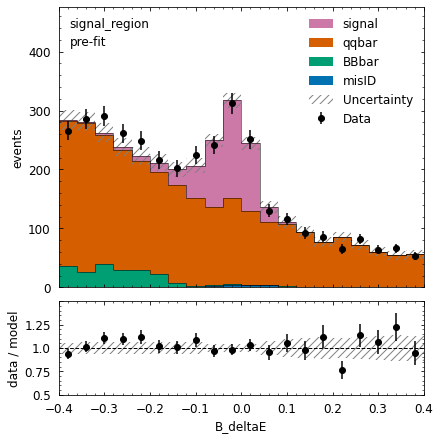

In [8]:
_ = cabinetry.visualize.data_mc_from_histograms(config)

# 2. Create a pyhf workspace

In [136]:
workspace_path = "B2Kpi0_workspace.json"
spec = cabinetry.workspace.build(config)
cabinetry.workspace.save(spec, workspace_path)

INFO - cabinetry.workspace - building workspace
DEBUG - cabinetry.workspace - adding NormFactor signal_norm to sample signal in region signal_region
DEBUG - cabinetry.workspace - adding NormFactor qqbar_norm to sample qqbar in region signal_region
DEBUG - cabinetry.workspace - adding NormFactor BBbar_norm to sample BBbar in region signal_region
DEBUG - cabinetry.workspace - adding NormFactor misID_norm to sample misID in region signal_region
INFO - pyhf.workspace - Validating spec against schema: workspace.json
DEBUG - cabinetry.workspace - saving workspace to B2Kpi0_workspace.json


In [137]:
print(json.dumps(spec, sort_keys=True, indent=4))

{
    "channels": [
        {
            "name": "signal_region",
            "samples": [
                {
                    "data": [
                        1.6199999999999968,
                        2.4899999999999984,
                        3.8100000000000094,
                        5.804999999999972,
                        9.47999999999998,
                        16.755000000000255,
                        29.415000000000735,
                        60.75000000000192,
                        124.00500000000432,
                        181.34999999995594,
                        124.56000000000434,
                        27.345000000000656,
                        3.9600000000000106,
                        1.289999999999999,
                        0.6450000000000005,
                        0.27000000000000013,
                        0.2250000000000001,
                        0.12,
                        0.075,
                        0.06
                    ],
   

INFO - pyhf.workspace - Validating spec against schema: workspace.json
INFO - pyhf.pdf - Validating spec against schema: model.json
INFO - pyhf.pdf - adding modifier BBbar_norm (1 new nuisance parameters)
INFO - pyhf.pdf - adding modifier misID_norm (1 new nuisance parameters)
INFO - pyhf.pdf - adding modifier qqbar_norm (1 new nuisance parameters)
INFO - pyhf.pdf - adding modifier signal_norm (1 new nuisance parameters)
INFO - pyhf.pdf - adding modifier staterror_signal_region (20 new nuisance parameters)
INFO - cabinetry.visualize.utils - saving figure as figures/modifier_grid.pdf


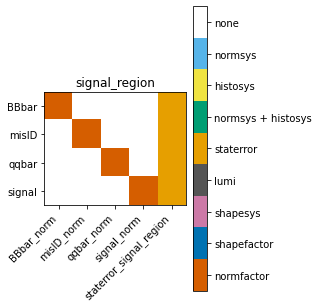

In [138]:
cabinetry.visualize.modifier_grid(pyhf.Workspace(spec).model())

In [139]:
model, data = cabinetry.model_utils.model_and_data(spec)

INFO - pyhf.workspace - Validating spec against schema: workspace.json
INFO - pyhf.pdf - Validating spec against schema: model.json
INFO - pyhf.pdf - adding modifier BBbar_norm (1 new nuisance parameters)
INFO - pyhf.pdf - adding modifier misID_norm (1 new nuisance parameters)
INFO - pyhf.pdf - adding modifier qqbar_norm (1 new nuisance parameters)
INFO - pyhf.pdf - adding modifier signal_norm (1 new nuisance parameters)
INFO - pyhf.pdf - adding modifier staterror_signal_region (20 new nuisance parameters)


# 3. MLE

In [140]:
pyhf.set_backend('numpy','scipy')
parameters = pyhf.infer.mle.fit(data=data, pdf=model)
fit_results = cabinetry.fit.fit(model=model, data=data,init_pars=list(parameters))

INFO - cabinetry.fit - performing maximum likelihood fit
INFO - cabinetry.fit - Migrad status:
┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 84.29                      │              Nfcn = 893              │
│ EDM = 2.92e-08 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │       SOME Parameters at limit       │
├──────────────────────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴───────

In [ ]:
for label, result, unc in zip(fit_results.labels, fit_results.bestfit, fit_results.uncertainty):
    print(f"{label}: {result:.3f} +/- {unc:.3f}")

INFO - cabinetry.visualize.utils - saving figure as figures/pulls.pdf


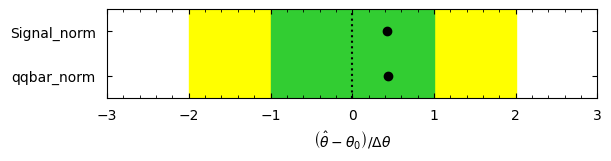

In [15]:
cabinetry.visualize.pulls(fit_results)

In [ ]:
cabinetry.visualize.correlation_matrix(fit_results, pruning_threshold=0.1)

DEBUG - cabinetry.model_utils - total stdev is [[67.7, 64.8, 62.4, 61.3, 61.9, 63.7, ..., 38.3, 35.1, 32.9, 31.7, 30, 29.2]]
DEBUG - cabinetry.model_utils - total stdev per channel is [349]
INFO - cabinetry.visualize.utils - saving figure as figures/signal_region_prefit.pdf


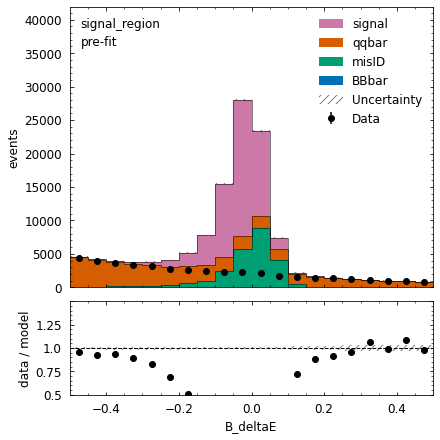

In [101]:
model_pred = cabinetry.model_utils.prediction(model)
figures = cabinetry.visualize.data_mc(model_pred, data, config=config)

DEBUG - cabinetry.model_utils - total stdev is [[72, 67.8, 62.4, 58.4, 60.4, 47.8, ..., 26.6, 24.7, 23.6, 22.7, 21.5, 20.9]]
DEBUG - cabinetry.model_utils - total stdev per channel is [370]
INFO - cabinetry.visualize.utils - saving figure as figures/signal_region_postfit.pdf


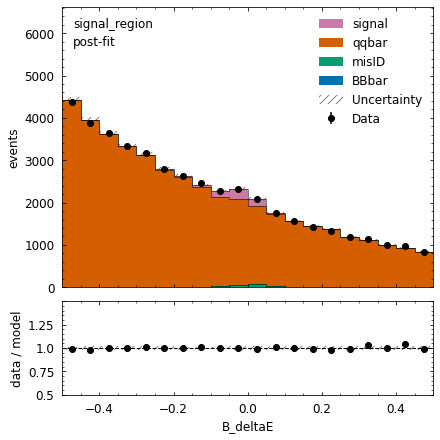

In [102]:
model_pred_postfit = cabinetry.model_utils.prediction(model, fit_results=fit_results)
_ = cabinetry.visualize.data_mc(model_pred_postfit, data, config=config)

# 4. Asimov and Toys

In [ ]:
asimov_data = cabinetry.model_utils.asimov_data(model)
_ = cabinetry.fit.fit(model, asimov_data)

In [14]:
# init the norm parameters
pars_toy = model.config.suggested_init()
pars_toy[:2] = [0.5, 0.5]
print(f"init parameters: {list(zip(model.config.parameters, pars_toy))}")

# make the pdfs
pdf_toy = model.make_pdf(pyhf.tensorlib.astensor(pars_toy))

# note: pdf.sample takes in a "shape" N=(10000,) given the number of samples
n_samples = 10
mc_toy = pdf_toy.sample((n_samples,))

print(mc_toy.shape)

init parameters: [('qqbar_norm', 0.5), ('signal_norm', 0.5), ('staterror_signal_region', 1.0)]
(10, 100)


In [15]:
init_pars = model.config.suggested_init()
par_bounds = model.config.suggested_bounds()
fixed_params = model.config.suggested_fixed()

qtilde_sig = pyhf.tensorlib.astensor(
    [
        pyhf.infer.test_statistics.qmu_tilde(
            1.0, mc, model, init_pars, par_bounds, fixed_params
        )
        for mc in mc_toy
    ]
)

WARNING - pyhf.infer.test_statistics - qmu_tilde test statistic used for fit configuration with POI not bounded at zero.
Use the qmu test statistic (pyhf.infer.test_statistics.qmu) instead.
WARNING - pyhf.infer.test_statistics - qmu_tilde test statistic used for fit configuration with POI not bounded at zero.
Use the qmu test statistic (pyhf.infer.test_statistics.qmu) instead.
WARNING - pyhf.infer.test_statistics - qmu_tilde test statistic used for fit configuration with POI not bounded at zero.
Use the qmu test statistic (pyhf.infer.test_statistics.qmu) instead.
WARNING - pyhf.infer.test_statistics - qmu_tilde test statistic used for fit configuration with POI not bounded at zero.
Use the qmu test statistic (pyhf.infer.test_statistics.qmu) instead.
WARNING - pyhf.infer.test_statistics - qmu_tilde test statistic used for fit configuration with POI not bounded at zero.
Use the qmu test statistic (pyhf.infer.test_statistics.qmu) instead.
WARNING - pyhf.infer.test_statistics - qmu_tilde t

In [65]:
init=[0.5, 0.5] + [1]*50
toys = model.make_pdf(pyhf.tensorlib.astensor(np.asarray(init))).sample((1,))
_ = cabinetry.fit.fit(model=model, data=toys[0])

INFO - cabinetry.fit - performing maximum likelihood fit
INFO - cabinetry.fit - Migrad status:
┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 248                        │             Nfcn = 4108              │
│ EDM = 0.000116 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │        No Parameters at limit        │
├──────────────────────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴───────